# Extending Large Concept Models for KVCache Compression

Last month, Meta published a paper on [Large Concept Models (LCMs)](https://arxiv.org/pdf/2412.08821), introducing a novel approach to language modeling focused on next-concept embedding prediction rather than next-token prediction. The architecture has three transformer components: a token-to-concept encoder, the concept decoder (the LCM), and a concept-to-token decoder.

The token-to-concept encoder maps token chunks into the concept embedding space, capturing high-level semantics. The concept decoder refines these embeddings and predicts the next concept embedding from context. The concept-to-token decoder projects the output embedding back into token space to generate text. By operating in the concept space, the model captures and manipulates semantic relationships more effectively than token-based models.

The paper uses a pretrained encoder/decoder architecture called SONAR but requires carefully curated input sequences, as embedding quality declines with longer or more complex inputs. The authors assume input sentences average 10–20 tokens and cap sentence length at 200 characters to preserve semantic relationships.

## Methodology and Approach

Seeing that LCM enables using a concecpt to represent multiple tokens, I propose leveraging LCM as an approach to compress the KV Cache across time. As a result, I have made some modifications:
- I propose jointly training the token-to-concept encoder, concept decoder, and concept-to-token decoder, as opposed to using a pretrained encoder/decoder through SONAR to avoid its constraints requiring careful selection of sequences.
- For simplicity, I have also opted to work without the diffusion-based variant of LCMs, despite their better performance demonstrated in the paper.
- For simplicity, I treat blocks of consecutive tokens as concepts with fixed concept size, instead of having dynamic sized concepts.

### Implementation Specifics

The token-to-concept encoder is a standard encoder with an added mask, disabling attending to "future concepts" ie). tokens after its current token chunk. The concept decoder (ie. LCM model) is the same as a standard decoder entirely except working in the compressed concept space. The final concept-to-token decoder takes both the input embedding `x` and the output concept embedding `z`, and first applies attention to the `x` and then applies cross attention with `z`. I also employed the following different reduction strategies when going from the token embedding space to the compressed concept space:
- Sum
- Max
- Learned Weighted Sum 
- Attention based reduction

All these implementation details can be see in [`train.py`](../train.py#L514) under the `forward_pass`. Further specifics below:
- [`encoder_block`](../train.py#L568)
- [`concept_decoder_block`](../train.py#L664)
- [`token_decoder_block`](../train.py#L776)


In [1]:
# %%
from plot_helper import *

In [2]:
# %%

TASK_IDS = [
    "58b7c60aa20e485d9c74a43819f720d5",
    "66b4c6f95b0e415aa26888bfc6efddf2",
    "ce8a074185ad4e91a9e9a721ff57f61a",
    "af54a412b286431fa2340e85c69ed293",
    "a7752a2b82254371a109e01c6661b271",
    "c6f92dce47d74c59a2a087aec3e34f41",
    "9c6b027deac04ce09822eecd02941420",
    "ca4c293546154ff9ad8da4446f22ddce",
    "e708aba99f9c4df7b21492e5b5366036",
    "cb467050886d4c0797d91ea6023ffd3d",
    "10e58923831e4f6e8efd18a8e00e83f8",
    "1d449329ac3f4d0fa3bf6d173f439c7b",
    "bb5b1ccedec745848754ca74ba60a28a",
    "0fd0a497fddf4223b7accdeecd5d6e35",
    "0bd01bebd9d340a29f691547dbf21426",
    "9d7ae33dd76e41f58e93a23ec123b7ca",
    "1c2d88bfe3a04e11829e693190c02001",
    "d3a41adb55954745b2a318ebc9032c1b",
    "7a72052b8b13468c9275ba29b822bfb1",
    "ad3801064a184e2994c25cf809c3dd8e",
    "f55f3b2c16d144e49104efa586c720fe",
    "65699e524fa949d28f0c230bab491975",
    "a9969ae1607743909d96ac01920c3450",
    "740a6bb93f154b2d8d6305f0a910017d",
    "a3ad577ce7b34c9d9d46e9817984a6a7",
    "71bd9272da784e24b873cdefc4b4e5bd",
    "1f6f0d9d48dc489084c52a5efd88cfa5",
    "a6e8960119474f9daad1965cdcfaac84",
    "e7c7513328474b8ba2738c63b493a064",
    "1fd109b244e6495aae54884d573dacd3",
    "ff77efbccb104aba8f719d258cde91ad",
    "979eba69eb8545b8892061fcdc4fbeaa",
    "d9e0de8de9714db8ae5ba6676c4bfed8",
    "e537b35e73394fb18ff047099aeba1a0",
    "cf39a009b8a84a9484972b6243a6faea",
    "c6107cde375f4840af40e3b64bde06eb",
    "eaad1a5b209646e690087e1e7f92f198",
]

In [3]:
# %%
metrics_data, config_data = get_metrics_data(TASK_IDS)

Loss not found for task 1f6f0d9d48dc489084c52a5efd88cfa5 with name slim_v4-32_31m_block_size=2_n_e_layers=2_n_t_layers=3_reduction_strategy=attn_n_kv=64_layers=3_n_kv=64
Loss not found for task e7c7513328474b8ba2738c63b493a064 with name slim_v4-32_31m_block_size=2_n_e_layers=4_n_t_layers=6_reduction_strategy=attn_layers=6
Loss not found for task c6107cde375f4840af40e3b64bde06eb with name slim_v4-32_31m_block_size=2_n_e_layers=8_n_t_layers=8_reduction_strategy=attn_n_kv=128_layers=8_n_kv=128_learning_rate=0.00675


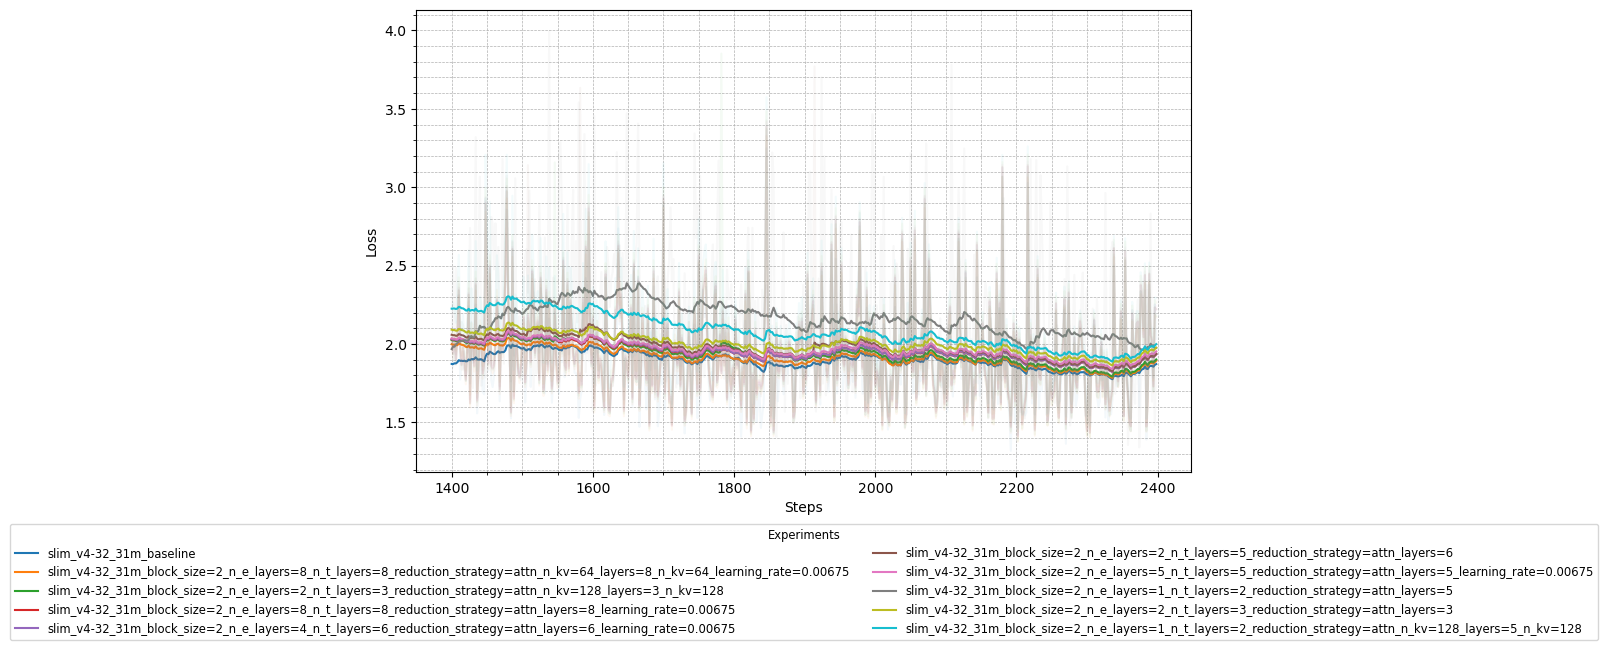

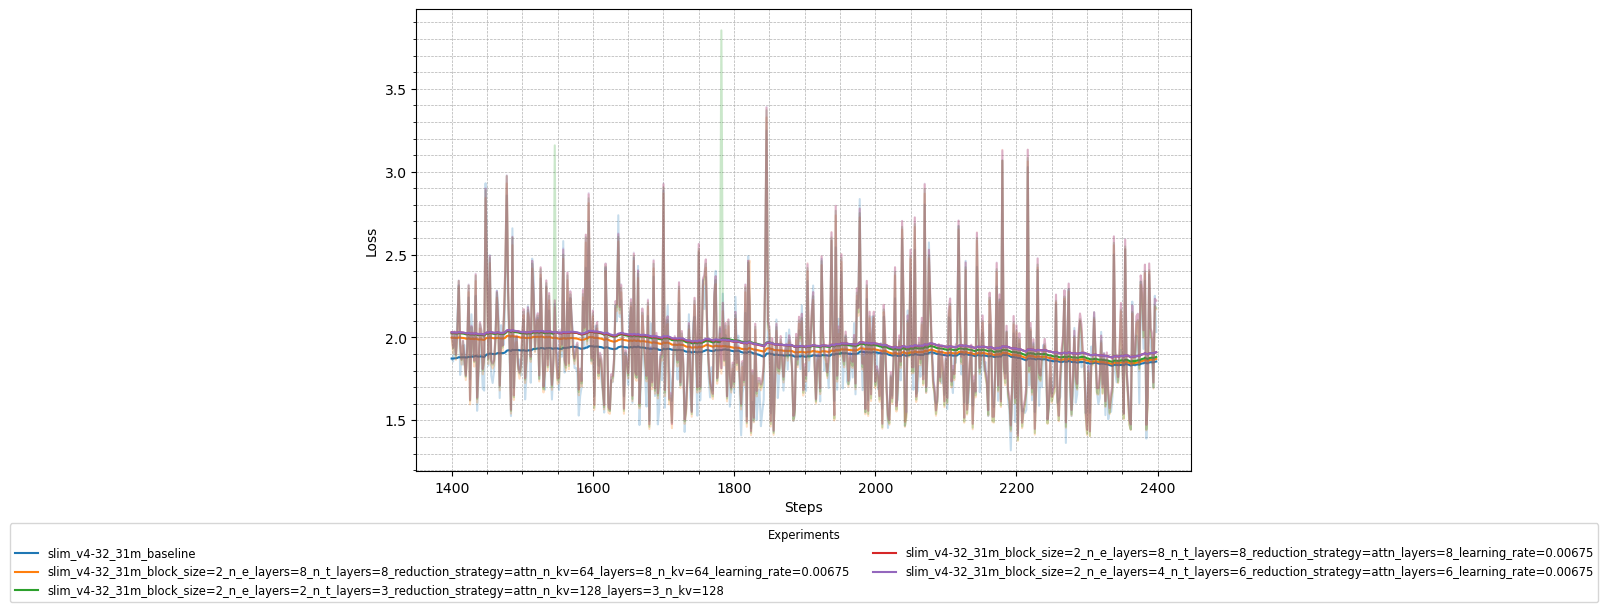

In [4]:
# %%

plot_loss_data(metrics_data, plot_last=500, ema_smoothing=0.97, top_k=10, opacity=0.05)
plot_loss_data(metrics_data, plot_last=500, ema_smoothing=0.99, top_k=5)

In [5]:
top_k_metrics_data = get_top_k_experiments(metrics_data, k=10, ema_smoothing=0.97)
get_eval_metrics_table(metrics_data, config_data)

,Name,Eval Loss,Block_Size,Concept_Decoder_Layers,Encoder_Layers,Token_Decoder_Layers,Reduction_Strategy,Attention_Heads,Query_Per_Key_Value,Learning_Rate
0,slim_v4-32_31m_baseline,1.849695,-,8,-,-,-,16,1,0.013500
1,slim_v4-32_31m_block_size...,1.867000,2,8,8,8,attn,64,1,0.006750
2,slim_v4-32_31m_block_size...,1.874595,2,3,2,3,attn,128,1,0.013500
3,slim_v4-32_31m_block_size...,1.908515,2,8,8,8,attn,16,1,0.006750
4,slim_v4-32_31m_block_size...,1.908937,2,6,4,6,attn,16,1,0.006750
5,slim_v4-32_31m_block_size...,1.911174,2,6,2,5,attn,16,1,0.013500
6,slim_v4-32_31m_block_size...,1.927374,2,5,5,5,attn,16,1,0.006750
7,slim_v4-32_31m_block_size...,1.936809,2,3,3,3,attn,16,2,0.013500
8,slim_v4-32_31m_block_size...,1.949907,2,3,2,3,attn,16,1,0.013500
9,slim_v4-32_31m_block_size...,1.968789,2,5,1,2,attn,128,1,0.013500
